In [1]:
##########################
##  tutorial3_flock.py  ##
##########################
# the dataset 'data/Ominimal_model3_small_5000f.pkl' simulates the dynamic 
# of N=500 flocking particles. The goal of this tutorial is to create a 
# "twin" simulation of the original data with identical properties. 
# - step 1 : get the statistical distribution of the particles
# - step 2 : process SFI 
# - step 3 : analysis of the harmonic terms 
# - step 4 : process the "twin" simulation
# - step 5 : compare the polarity autocorroletation function
# - step 6 : process video 

In [10]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import dill
import os

from sfiabp.base import base
from sfiabp.base import base2ptrigo
from sfiabp.general import addfunction
from sfiabp.vectorial import multicore
from sfiabp.vectorial import simulation

from sfiabp.display.video import create_video
from sfiabp.display.sweep import sfidisp_sweep

from sfiabp.general.addfunction import getpkl 

In [11]:
# Output folder
SubDir = 'tutorial/tuto3'
os.makedirs(SubDir,exist_ok=True)

# original data file
PathDataFile = ('data/Ominimal_model3_small_5000f.pkl')
# sfi file
PathSfiFile = SubDir + '/S_Trigo_200f.pkl'
# simulation file after inference
PathSimFile = SubDir + '/Sim_Trigo_200f.pkl'
# video file
PathVideoFile = SubDir + '/Video_Trigo_200f.mp4'

# Sim = getpkl(PathDataFile)
# np.shape(Sim['X_Raw'])

In [ ]:
Sim = getpkl(PathDataFile)
Sim.keys()
Sim['xframelim']

# Path = SubDir + '/S_Trigo_1000f.pkl'
# Sabp = getpkl(Path)
# print(Sabp['cof1p'][0][2])
# Sabp['active_vel'] = Sabp['cof1p'][0][2]
# with open( Path, 'wb') as outp:
#     dill.dump( Sabp, outp )


array([  0., 200.])

In [ ]:
#### step 1 : get the statistical distribution of the particles ####
# To kwow better the original data, we first process the histogram of 
# the distribution of neigbors around a particle, with the function polar_histo.  
# It allows to assess the areas with stronger/lower statistics in the (theta_1, theta_2) plane.
# Then, we process the radial pair correlation g(r) to assess the minimal neighbor distance rmin 
# for which the inference starts being reliable. From the graph, we estimate rmin = 4-5 um.   

from sfiabp.general.observables import polar_histo
from sfiabp.general.observables import histo1d

# get data 
Data = getpkl(PathDataFile)
# cell dimension (um)
lcell = Data['lcell'] # 20 um
# radial bins (um) 
vecr = np.linspace(0,lcell,2*lcell+1,endpoint=True) # dr = 0.5 um
# angular bin (rad)
veca = (np.pi/180)*np.linspace(0,360,36+1,endpoint=True) # dtheta = 10 deg
# frame number to process
nframe = 5000

# process 2D histo 
histo = polar_histo( Data['X_Raw'][:nframe], Data['xframelim'].astype(int), Data['yframelim'].astype(int), vecr, veca, ncore=5 )
# process 1D histo
vr,h1,h1n=histo1d(vecr,histo)

# collect histograms in a dictionnary  
Data['histo'] = dict(vecr=vecr,veca=veca,histo=histo,h1=h1,h1n=h1n,nframe=nframe)
# save histograms in the data file
with open( PathDataFile, 'wb') as outp:
    dill.dump( Data, outp )


pid =  14586
pid =  14587
pid =  14588
pid =  14589
pid =  14590
iprocess =  0 , frame =  0
iprocess =  1 , frame =  0
iprocess =  2 , frame = iprocess =   03
 , frame =  0
iprocess =  4 , frame =  0
iprocess =  0 , frame =  1
iprocess =  1 , frame =  1
iprocess =  3 , frame =  1
iprocess =  4 , frame = iprocess =   12
 , frame =  1


Process ForkPoolWorker-5:
Process ForkPoolWorker-2:
Process ForkPoolWorker-3:
Process ForkPoolWorker-1:
Process ForkPoolWorker-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/jerome/anaconda3/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/jerome/anaconda3/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/jerome/anaconda3/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/jerome/anaconda3/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jerome/anaconda3/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jerome/anaconda3/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*se

KeyboardInterrupt: 

-- resolution histogram --
distance dr (um):  0.5
angle da (°):  10.0


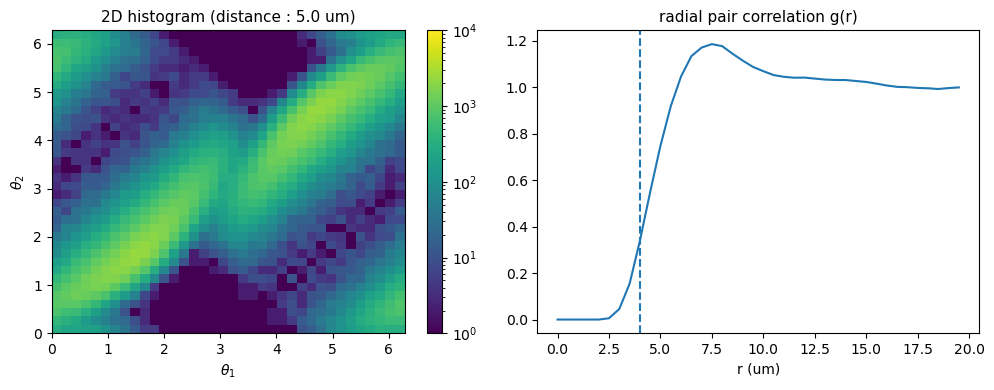

In [4]:
## plot the histograms

# get data
Data = getpkl(PathDataFile) 

# creation of the figure
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
fontisze = 11

# plot the 2D histogram
histo = Data['histo']['histo'] # histogram
vecr = Data['histo']['vecr'] # radial bins 
veca = Data['histo']['veca'] # angular bins
# histo = Sabp['psfi']['histo'][0] # histogram
# vecr = Sabp['psfi']['histo_vecr'] # radial bins 
# veca = Sabp['psfi']['histo_veca'] # angular bins
dij = 5 # interparticle distance (um) 
ir = np.where(dij-vecr >= 0, dij-vecr, np.inf).argmin()
ti,tj = np.meshgrid(veca,veca)
pcm0 = ax1.pcolormesh( ti, tj, histo[ir],
            cmap='viridis',norm=colors.LogNorm(vmin=1,vmax=1e4,clip=True))  
fig.colorbar(pcm0)
ax1.set_title( "2D histogram (distance : %.1f um)"%(dij),fontsize=fontisze)
ax1.set_xlabel('$\\theta_1$')
ax1.set_ylabel('$\\theta_2$')

# plot the radial pair correlation g(r)
ax2.plot(vecr[:-1],Data['histo']['h1n'])
ax2.set_title('radial pair correlation g(r)',fontsize=fontisze)
ax2.set_xlabel('r (um)')
ax2.axvline(4,ls='--')

fig.tight_layout()

print('-- resolution histogram --')
print('distance dr (um): ', vecr[1]-vecr[0])
print('angle da (°): ', (veca[1]-vecr[0])*180/np.pi)

In [ ]:
#### step 2 : process SFI ####        
# To infer the interactions, we apply the SFI analysis with the trigonometric basis functions
# described in the article, at second order (No=2)

## parameters
# starting frame 
istar = 0
# number of frame 
nfra = 1000
# additional GWN on orientation (deg)
stdGWN = 0
# time between frame (s)
dtframe = 0.1
# box boundaries (um)
xboxlim = np.array([0,200]) 
yboxlim = np.array([0,200])
# cell length (um)
lcell = 20 
# Core number
ncore = 5

# choose the drift basis function
# polar coordinates -> see notation in the draft
basis_name = 'Trigo'
if basis_name == 'Trigo': 
    # 1 particle function
    fun1p = [ base.stdfun1p() ] 
    # 2 particles function
    # Order, FuncRad, VectorRad
    Order = 2
    FuncRad = 'PolyExp'
    VectorRad = np.arange(0,16,2)
    lbase = base2ptrigo.polartrigo( Order, FuncRad, VectorRad )[0]
    fun2p = [ base.convcart( lbase ) ]

# drift mode : 'Ito', 'Stratonovich', 'Ito-shift', 'Stratonovich-old' 
# drift_mode = 'Ito'
drift_mode = 'Stratonovich'
# inverse_mode : 'pinv', 'tikhonov'
inverse_mode = {'name':'pinv'}
# inverse_mode = {'name':'tiko','alpha':1e-5}

## algorithm - process sfi
# get data
with open( PathDataFile, 'rb' ) as inp:    
    data0 = dill.load(inp)
list_data = data0['X_Raw'][istar:istar+nfra]
# add noise 
addfunction.addGWnoise(list_data,stdGWN*(np.pi/180))
# process sfi algo
cof1p, cof2p, D_average, psfi = multicore.sfi(list_data,dtframe,fun1p,fun2p,xboxlim,yboxlim,lcell,ncore,
                                                    drift_mode=drift_mode,inverse_mode=inverse_mode,histo_mode=True,verbose=True)
 
# create Sabp dict specific to our study
Sabp = dict( cof1p = cof1p, cof2p = cof2p,
             active_vel = cof1p[0][2],
             D_average = D_average, psfi = psfi,
             data_file = os.path.basename(PathDataFile),
             frame_init = list_data[0],
             iid = np.array([istar,istar+nfra]),
             basis_name = basis_name, 
             Order = Order,  
             FuncRad = FuncRad,  
             VectorRad = VectorRad )

# save Sabp dict
with open( PathSfiFile, 'wb') as outp:
    dill.dump( Sabp, outp )


add noise
pid: 85370 , process: 0 , pre process ...
pid: 85371 , process: 1 , pre process ...
process: 0 , process sfi ...pid:
 process: 853721  , process:, process sfi ...2
  pid:, pre process ... 
85373 , process: 3 , pre process ...
pid: 85374 , process:process: 4  2, pre process ...process:  
, process sfi ...
3 , process sfi ...
process: 4 , process sfi ...
process: 3 , frame: 1 / 199
process: 4 , frame: 1 / 199
process: 1 , frame: 1 / 200
process: 2 , frame: 1 / 200
process: 0 , frame: 1 / 200
process: 3 , frame: 2 / 199
process: 4 , frame: 2 / 199
process: 1 , frame: 2 / 200
process: 2 , frame: 2 / 200
process: 0 , frame: 2 / 200
process: 3 , frame: 3 / 199
process: 4 , frame: 3 / 199
process: 1 , frame: 3 / 200
process: 2 , frame: 3 / 200
process: 0 , frame: 3 / 200
process: 3 , frame: 4 / 199
process: 4 , frame: 4 / 199
process: 1 , frame: 4 / 200
process: 2 , frame: 4 / 200
process: 3 , frame: 5 / 199
process: 0 , frame: 4 / 200
process: 4 , frame: 5 / 199
process: 1 , frame:

9.910451351350478


In [5]:
# print info / report 
from sfiabp.general.addfunction import get_listpkl
from sfiabp.general.addfunction import print_report

list_Sabp, listSabpFileName = get_listpkl(SubDir,'S_') 

## open S dict
for i in range(len(list_Sabp)): 
    print_report(list_Sabp[i], listSabpFileName[i])


-----------------------------------------------------------
--- StochasticForceInference report for ABP particles ---
-----------------------------------------------------------
S File name :  S_Trigo_0200f.pkl
Dimension xbox (um):  [  0 200]
Dimension ybox (um) :  [  0 200]
cell length (um) :  20
N frame processed :  198
stat weight: 63106
pair stat weight: 949670
neigbor per particle :  15.048806769562324
Drift mode: Stratonovich
Stratonovich difference mode: ABP_Vestergaard
Inverse mode :  {'name': 'pinv', 'opt': 'v1', 'conditional_number': inf}
B mode :  rectangle
# Abp results
Data file name :  Ominimal_model3_small_5000f.pkl
N particle (in first frame) :  500
Frame range :  [  0 200]
Basis name: Trigo
Active velocity (um/s) :  9.908315819592703
Rotational Diffusion (/s) :  0.1310673962783602
Order: 2
FuncRad: PolyExp
VectorRad: [ 0  2  4  6  8 10 12 14]

-----------------------------------------------------------
--- StochasticForceInference report for ABP particles ---
--------

In [ ]:
#### step 3 : analysis of the harmonic terms ####
# The inferred coefficients a_{n,k}(r) provided by SFI are compared with the analytical ones.
# We find good agreement at all different orders (0,1,2) within the range [5,20] um
# where the statistics is correct. 

import sfiabp.vectorial.analytics as analytics

## First, we expand the theoretical function on the same trigonometric
# basis used for SFI. 
# get the vectorial function to fit in polar coordinates (r,theta1,theta2) 
lfun = analytics.minimalmodel3()

# grid definition
vecr = np.linspace(3,20,34,endpoint=False) # um
vecai = (np.pi/180)*np.linspace(0,360,36,endpoint=False) # rad
vecaj = (np.pi/180)*np.linspace(0,360,36,endpoint=False) # rad

# Basis functions
basis_name = 'Trigo' 
# note fun1p also accept the concatenated function base.stdfun1p(), such as fun1p = [ base.stdfun1p() ] 
#fun1p = [ base.stdfun1p() ] 
## 2 particles force
# Order, FuncRad, VectorRad
Order = 2
FuncRad = 'PolyExp'
VectorRad = np.arange(0,16,2)
list_base = base2ptrigo.polartrigo( Order, FuncRad, VectorRad )[0] # list_base

## 3D scalar product
cof2p = analytics.sfiprod3d(lfun,list_base,vecr,vecai,vecaj,Mode_ACCL=True)
phicof = np.reshape( cof2p,np.prod(np.shape(cof2p)) )
# get the harmonic functions a_{n,k}(r) 
lffradnum = base2ptrigo.InitListFunc( Order, FuncRad, VectorRad, phicof )[1]

Preprocess function
Preprocess base function
memory = 7402752
Component : 0, done
Component : 1, done
Component : 2, done


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


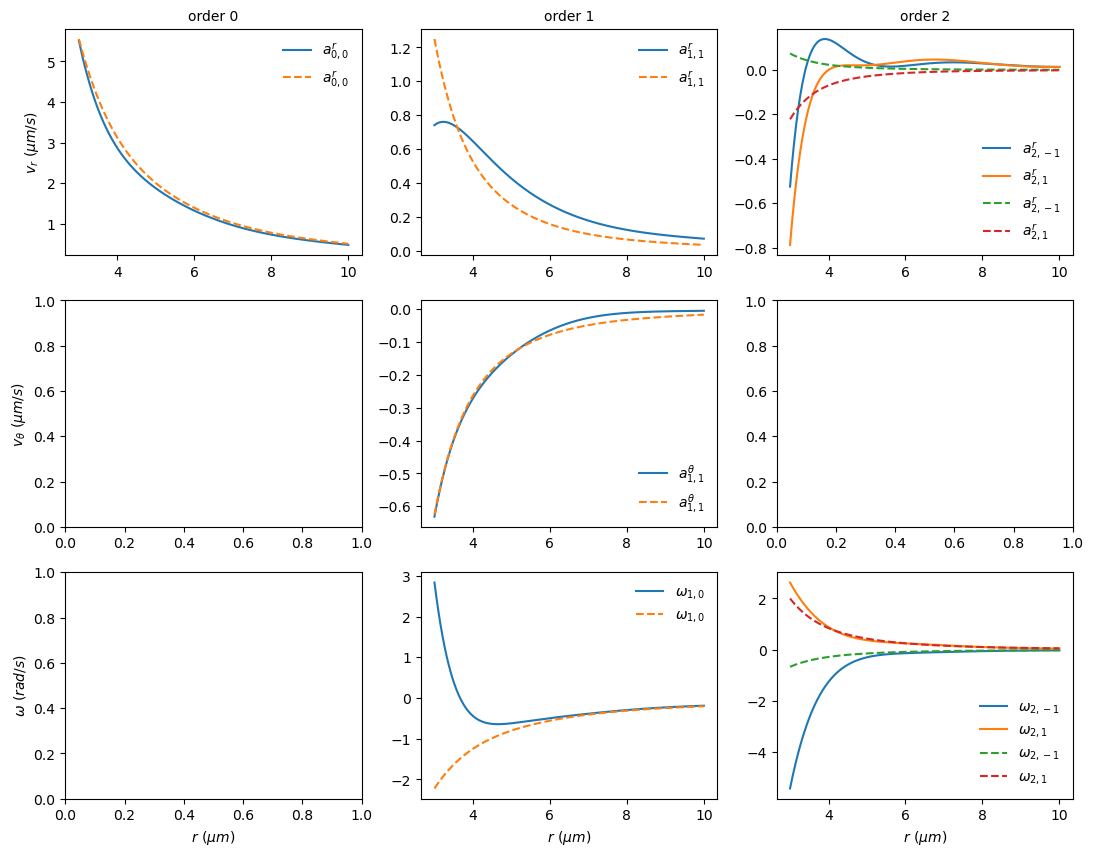

In [8]:
## plot the harmonic functions ##

# get the inferred coefficients a_{n,k}(r)
# Sabp = getpkl(SubDir+'/S_Trigo_0200f.pkl')
Sabp = getpkl(SubDir+'/S_Trigo_1000f.pkl')
lffrad = base2ptrigo.InitListFunc( Sabp['Order'], Sabp['FuncRad'], Sabp['VectorRad'], Sabp['cof2p'][0] )[1]

# create the figure 

s = 10
ratio = 1.3
fig, axs = plt.subplots( 3, 3, figsize=(s*ratio,s))

ftz_title = 10
ftz_label = 10
ftz_legend = 10

r = np.linspace(3,10,400)

## inferred terms
axs[0,0].plot(r,lffrad[0][0](r),label="$a^r_{0,0}$")
axs[0,1].plot(r,lffrad[0][2](r),label="$a^r_{1,1}$") # cos(aj)
axs[0,2].plot(r,lffrad[0][3](r),label="$a^r_{2,-1}$") # cos(ai-aj)
axs[0,2].plot(r,lffrad[0][5](r),label="$a^r_{2,1}$") # cos(ai+aj)
axs[1,1].plot(r,lffrad[1][2](r),label="$a^\\theta_{1,1}$") # sin(aj)
axs[2,1].plot(r,lffrad[2][1](r),label="$\\omega_{1,0}$") # sin(ai)
axs[2,2].plot(r,lffrad[2][3](r),label="$\\omega_{2,-1}$") # sin(ai-aj)
axs[2,2].plot(r,lffrad[2][5](r),label="$\\omega_{2,1}$") # sin(ai+aj)

## numerical terms
axs[0,0].plot(r,lffradnum[0][0](r),'--',label="$a^r_{0,0}$")
axs[0,1].plot(r,lffradnum[0][2](r),'--',label="$a^r_{1,1}$") # cos(aj)
axs[0,2].plot(r,lffradnum[0][3](r),'--',label="$a^r_{2,-1}$") # cos(ai-aj)
axs[0,2].plot(r,lffradnum[0][5](r),'--',label="$a^r_{2,1}$") # cos(ai+aj)
axs[1,1].plot(r,lffradnum[1][2](r),'--',label="$a^\\theta_{1,1}$") # sin(aj)
axs[2,1].plot(r,lffradnum[2][1](r),'--',label="$\\omega_{1,0}$") # sin(ai)
axs[2,2].plot(r,lffradnum[2][3](r),'--',label="$\\omega_{2,-1}$") # sin(ai-aj)
axs[2,2].plot(r,lffradnum[2][5](r),'--',label="$\\omega_{2,1}$") # sin(ai+aj)

# ## theoretical terms
# Arep = 50; Adip = 4; R = 1.5; V = 10; C = -20
# axs[0,0].plot(r, Arep/r**2,'--') # ar_0,0 
# axs[0,1].plot(r, V*R**3/(r**3),'--') # cos(aj)
# axs[0,2].plot(r, (3/2)*Adip/(r**4) ,'--') # cos(ai-aj)
# axs[0,2].plot(r, -(9/2)*Adip/(r**4),'--') # cos(ai+aj)
# axs[1,1].plot(r, -(1/2)*V*R**3/(r**3), '--' ) # np.sin(aj)
# axs[2,1].plot(r, C/r**2, '--' ) # sin(ai)
# axs[2,2].plot(r, -2*Adip*(R**2)/(r**3), '--' ) # np.sin(ai-aj)
# axs[2,2].plot(r, 6*Adip*(R**2)/(r**3), '--' ) # np.sin(ai+aj)

axs[0,0].set_title('order 0', fontsize=ftz_title)
axs[0,1].set_title('order 1', fontsize=ftz_title)
axs[0,2].set_title('order 2', fontsize=ftz_title)
axs[0,0].set_ylabel('$v_r\\ (\\mu m/s)$',fontsize=ftz_label)
axs[1,0].set_ylabel('$v_{\\theta}\\ (\\mu m/s)$',fontsize=ftz_label)
axs[2,0].set_ylabel('$\\omega\\ (rad/s)$',fontsize=ftz_label)
axs[2,0].set_xlabel('$r\\ (\\mu m)$',fontsize=ftz_label)
axs[2,1].set_xlabel('$r\\ (\\mu m)$',fontsize=ftz_label)
axs[2,2].set_xlabel('$r\\ (\\mu m)$',fontsize=ftz_label)

for i in range(3):
    for j in range(3):
        axs[i,j].legend(loc='best',frameon=False, fontsize=ftz_legend)



In [11]:
#### step 4 : process the "twin" simulation ####
# we now process the simulation with the inferred interactions. 
# In addition, a soft sphere potentiel interaction is added to emulate the kernel interaction.
# The main function to use is simulation.sim.  

## open S dict
if 'Sabp' not in 'locals':
    with open( PathSfiFile, 'rb' ) as inp:    
        Sabp = dill.load(inp)

#### parameters for simulation #### 

# particle diameter (um) 
d = 3.17
# number of frame
nfrasim = 5000
# time interval between each saved frame (s)
dtframe = Sabp['psfi']['dtframe']
# step for computation integration (s) 
dtinc = dtframe/20
# increment prerun 
prer = 0
# particle number (same as in the original file)
npar = np.shape(Sabp['frame_init'])[0]
# xlim (xbox dimension)
xlim = Sabp['psfi']['xboxlim'][1] 
# ylim
ylim = Sabp['psfi']['yboxlim'][1]
# cell length
lcell = Sabp['psfi']['lcell']

## definition of one particle force
# active force (um/s)
Us = Sabp['cof1p'][0][2]
# Force 1 particle 
fun1p = [base.active(Us)] # Activity   

## definition of two particle forces
# 1/ kernel force - soft sphere potential /
# SSP kernel diameter (um)
dkern = d
# SSP kernel intensity  
eps = 800
# 2/ pair force infered by sfi /
# the force is evaluated on a grid in the space (distance, polar angle i and j) 
# radial increment
dr = 0.1
# angular increment
da = 2*np.pi/180
# radial boundaries to process force 
# (see discussion in above cell)
R_bound = [ 4, lcell ]     
# Force 2 particles
fun2p = []
# Soft sphere potential (diameter and strenght)
fun2p.append( base.FijSSP(d,eps) )
# Trigonometric function
fun2p.append( base2ptrigo.Fij_Trigo_FullCut( Sabp, R_bound, dr, da ) )

## definition of the diffusion
# radial diffusion
Dr = Sabp['D_average'][2,2]   
# Force diffusion
fundiff = [base.Diffu(0,Dr)] # Translational, Rotational diffusion coef

# process simulation
SimData = simulation.sim(npar, nfrasim, dtframe, dtinc, xlim, ylim, lcell, fun1p, fun2p, fundiff, isim = 0, verbose = True, prer = prer)
# save SimData dict
with open( PathSimFile, 'wb') as outp:
    dill.dump( SimData, outp )


sim, pid :  12863 , isim :  0
isim :  0 , frame :  1 / 5000
isim :  0 , frame :  2 / 5000
isim :  0 , frame :  3 / 5000
isim :  0 , frame :  4 / 5000
isim :  0 , frame :  5 / 5000


KeyboardInterrupt: 

** data file **
nframe : 5000
dtframe (s) : 0.1
** sim file **
nframe : 5000
dtframe (s) : 0.1


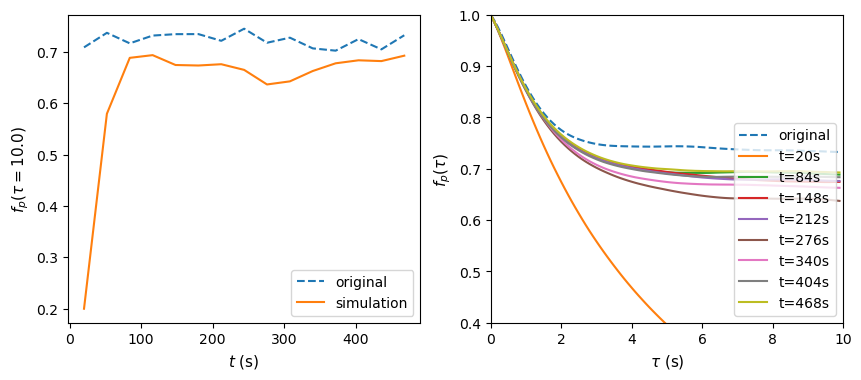

In [ ]:
#### step 5 : compare the polarity autocorroletation function ####
# we find a good agreement between the inferred and the original curves

from sfiabp.general.observables import npcorwin_sim
from sfiabp.general.observables import npcorwin_exp 

Data = getpkl(PathDataFile) 
DataSim = getpkl( PathSimFile  )

print('** data file **')
print('nframe :',len(Data['X_Raw']))
print('dtframe (s) :',Data['dtframe'])
print('** sim file **')
print('nframe :',len(DataSim['X_Raw']))
print('dtframe (s) :',Data['dtframe'])
dtframe = Data['dtframe']

# process fp polar autocorrelation on a sliding window of width 400 pts with 20% overlap.
fres, it, idmid = npcorwin_sim(Data['X_Raw'][:5000],400,ratio_recov=0.2,ncore=7)
fres_sim, it, idmid = npcorwin_sim(DataSim['X_Raw'][:5000],400,ratio_recov=0.2,ncore=7)
nsegment = np.shape(fres)[1]

ftz = 11
fz_legend = 10
fig , (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))

## evolution with time 
pt = 100
ax1.plot(idmid*dtframe, fres[pt,:], ls='--', label='original')
ax1.plot(idmid*dtframe, fres_sim[pt,:], label='simulation')
# ax1.set_xlim(0,npt*dtframe)
# ax1.set_ylim(0.4,1)
ax1.set_ylabel("$f_{p}(\\tau=%.1f)$"%(pt*dtframe),fontsize=ftz)
ax1.set_xlabel("$t$ (s)",fontsize=ftz)
ax1.legend(loc='lower right',fontsize=fz_legend)

## autocor function with tau
npt = 100
ax2.plot(it[:npt]*dtframe, fres[:npt,-1], ls='--', label='original')
# ax2.plot(it[:npt]*dtframe, fres_sim[:npt,-1], label='simulation')
for i in np.arange(0,nsegment,2):
    ax2.plot(it[:npt]*dtframe, fres_sim[:npt,i], label="t=%ds"%(idmid[i]*dtframe))
# ax2.plot(it[:npt]*dtframe, np.exp(-0.1*it[:npt]*dtframe),ls='--',c='0.5',label='$exp(-D_{r}\\tau)$')
# ax1.set_xlim(0.6,1)
ax2.set_xlim(0,npt*dtframe)
ax2.set_ylim(0.4,1)
ax2.set_ylabel("$f_{p}(\\tau)$",fontsize=ftz)
ax2.set_xlabel("$\\tau$ (s)",fontsize=ftz)
ax2.legend(loc='lower right',fontsize=fz_legend)


In [17]:
np.shape(fres_sim)

(300, 8)

In [ ]:
#### step 6 : process video ####
# It is possible to realize a video of the inferred simulation. 
# After a transitory regime, we should see the emrgence of the flock as in the original data

## parameters for video
# particle diameter (um) 
d = 3.17
# starting frame
istar_vid = 0
# number of frame 
nfra_vid = 5000
# sampling
ksamp = 4

## open SimData dict
if 'SimData' not in 'locals':
    with open( PathSimFile, 'rb' ) as inp:    
        SimData = dill.load(inp)

list_data_vid  = SimData['X_Raw'][istar_vid:istar_vid+nfra_vid]
# process video
create_video(SimData['X_Raw'],d,SimData['xframelim'],SimData['yframelim'],SimData['dtframe'],ksamp,PathVideoFile) 

i = 0
i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10
i = 11
i = 12
i = 13
i = 14
i = 15
i = 16
i = 17
i = 18
i = 19
i = 20
i = 21
i = 22
i = 23
i = 24
i = 25
i = 26
i = 27
i = 28
i = 29
i = 30
i = 31
i = 32
i = 33
i = 34
i = 35
i = 36
i = 37
i = 38
i = 39
i = 40
i = 41
i = 42
i = 43
i = 44
i = 45
i = 46
i = 47
i = 48
i = 49
i = 50
i = 51
i = 52
i = 53
i = 54
i = 55
i = 56
i = 57
i = 58
i = 59
i = 60
i = 61
i = 62
i = 63
i = 64
i = 65
i = 66
i = 67
i = 68
i = 69
i = 70
i = 71
i = 72
i = 73
i = 74
i = 75
i = 76
i = 77
i = 78
i = 79
i = 80
i = 81
i = 82
i = 83
i = 84
i = 85
i = 86
i = 87
i = 88
i = 89
i = 90
i = 91
i = 92
i = 93
i = 94
i = 95
i = 96
i = 97
i = 98
i = 99
i = 100
i = 101
i = 102
i = 103
i = 104
i = 105
i = 106
i = 107
i = 108
i = 109
i = 110
i = 111
i = 112
i = 113
i = 114
i = 115
i = 116
i = 117
i = 118
i = 119
i = 120
i = 121
i = 122
i = 123
i = 124
i = 125
i = 126
i = 127
i = 128
i = 129
i = 130
i = 131
i = 132
i = 133
i = 134
i = 135
i = 136
i = 137
i = 13

True

In [ ]:
%matplotlib notebook

import sfiabp.vectorial.analytics as analytics
# first get the analytical function
lfftheo = analytics.minimalmodel3()
# plot function
fig = sfidisp_sweep(SubDir, exact_fun = lfftheo, d = 3.17, rlim = [0,20],
                                            tishift = 0, tjshift = -np.pi, Prefix = 'S_' )

KeyError: 'cof1p'